# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics

In [2]:
df_car = pd.read_csv('https://raw.githubusercontent.com/pokengineer/DataScience/main/datasets/car_price.csv')
df_car.head(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


# ETL

In [4]:
def etl_dataset( df ): 
    # Torque
    df['RPM'] = df['torque'].str.extract(r'(\d+)rpm', expand=False)
    df['RPM'].fillna(df['torque'].str.extract(r'(\d{1,3}(?:,\d{3})*)\(kgm@ rpm\)', expand=False), inplace=True)
    df['RPM'].fillna(df['torque'].str.extract(r'(\d+) RPM', expand=False), inplace=True)
    df['RPM'].fillna(df['torque'].str.extract(r'(\d+)  rpm ', expand=False), inplace=True)
    df['RPM'].fillna(df['torque'].str.extract(r'(\d+) rpm', expand=False), inplace=True)
    df['TORQUE'] = df['torque'].str.extract(r'(\d+)Nm@', expand=False)
    df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+)nm@', expand=False), inplace=True)
    df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+) Nm', expand=False), inplace=True)
    df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+)@', expand=False), inplace=True)
    df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+)Nm', expand=False), inplace=True)
    df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+)  Nm', expand=False), inplace=True)
    df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+)NM@', expand=False), inplace=True)
    df['TORQUE'].fillna((df['torque'].str.extract(r'(\d{1,2}(?:[,.]\d{1,2})?)@\s*\d{1,3}(?:,\d{3})*\(kgm@ rpm\)', expand=False)).astype(float) * 9.8, inplace=True)
    df['TORQUE'].fillna((df['torque'].str.extract(r'(\d{1,2}(?:[,.]\d{1,2})?)\s*kgm', expand=False)).astype(float) * 9.8,inplace=True)
    df['RPM'] = df['RPM'].str.replace(',', '').astype(float)
    df['TORQUE'] = df['TORQUE'].astype(float)
    # Brand
    df['BRAND'] = df['name'].astype('str').apply(lambda x: x.split()[0])
    # Milage
    df['MILEAGE'] = (df['mileage'].apply(lambda x: str(x).replace(' kmpl', '').replace(' km/kg', ''))).astype(float)
    # Engine
    df['ENGINE'] = (df['engine'].apply(lambda x: str(x).replace(' CC', ''))).astype(float)
    # Max Power
    df['MAX_POWER'] = df['max_power'].astype(str).apply(lambda x: x.split()[0])
    df.drop(df[df['MAX_POWER'] == 'bhp'].index, inplace=True, axis=0)
    df['MAX_POWER'] = df['MAX_POWER'].astype(float)
    # Drop columns 
    return df.drop(['torque', 'name', 'mileage', 'engine', 'max_power'], axis=1)

In [5]:
df_car = etl_dataset( df_car )

# Analisis del Dataset

In [8]:
# Identificamos las variables categóricas para crear dummies o incluirla de otra forma
categorical = [var for var in df_car.columns if df_car[var].dtype=='O']
print('las variables categoricas son:\n', categorical)
print("\nchequeamos la dimensionalidad de las variables")
for var in categorical:
    print(len(df_car[var].unique()), ' valores unicos en ', var )

las variables categoricas son:
 ['fuel', 'seller_type', 'transmission', 'owner', 'BRAND']

chequeamos la dimensionalidad de las variables
4  valores unicos en  fuel
3  valores unicos en  seller_type
2  valores unicos en  transmission
5  valores unicos en  owner
32  valores unicos en  BRAND


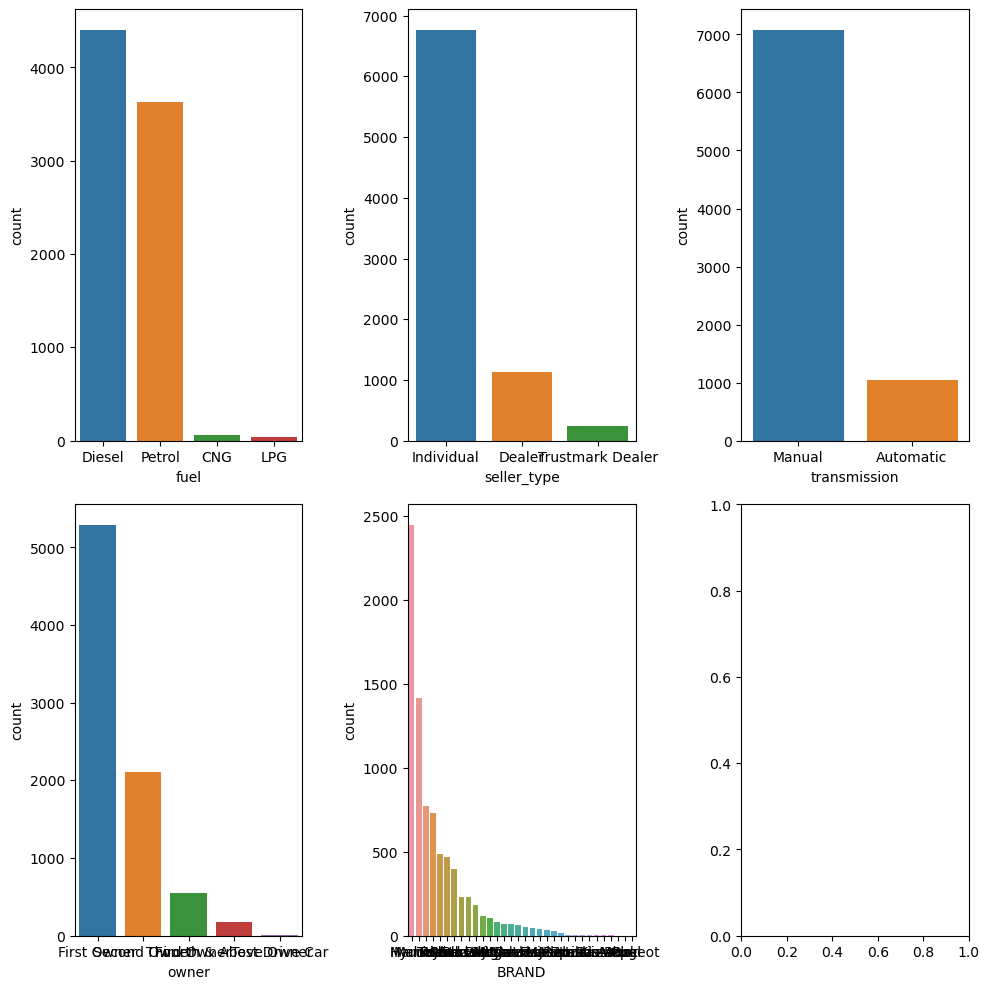

In [27]:
cat_cols_count = len(categorical)
cat_rows = cat_cols_count // 3
cat_rows += 1 if cat_cols_count % 3 != 0 else 0  # Eğer sütun sayısı 3'e tam bölünmüyorsa bir ek satır oluştur.

fig, axes = plt.subplots(cat_rows, 3, figsize=(10, 10), squeeze=True)
axes = axes.flatten()

for i, col in enumerate(categorical):
    sns.countplot(data=df_car, x=col, ax=axes[i], order=df_car[col].value_counts().index)
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

In [9]:
# identificamos las variables numéricas
numerical = [var for var in df_car.columns if df_car[var].dtype!='O']
print('las variables numéricas son:\n', numerical)

las variables numéricas son:
 ['year', 'selling_price', 'km_driven', 'seats', 'RPM', 'TORQUE', 'MILEAGE', 'ENGINE', 'MAX_POWER']


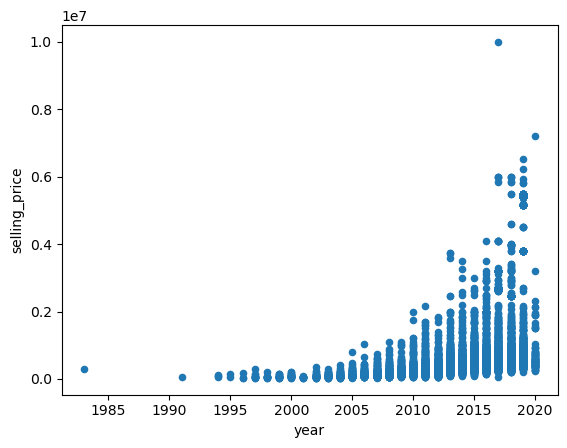

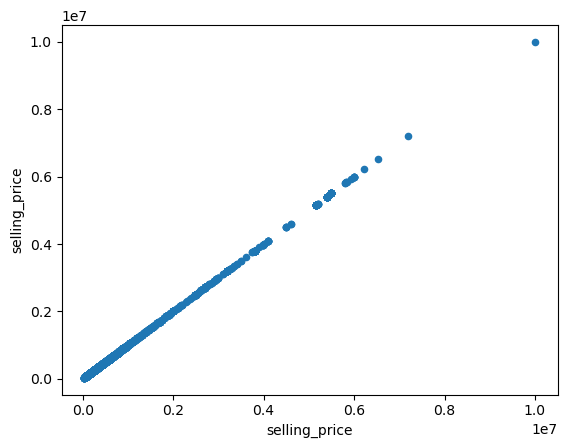

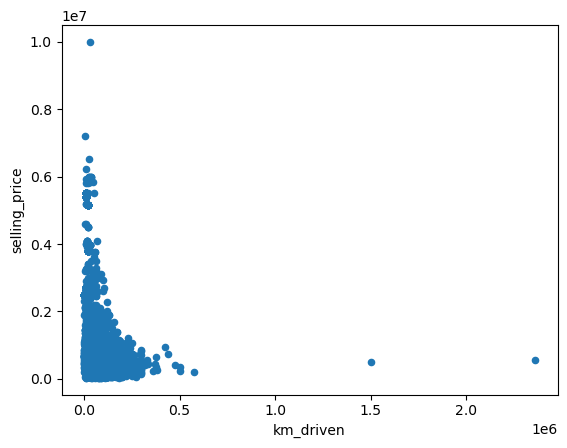

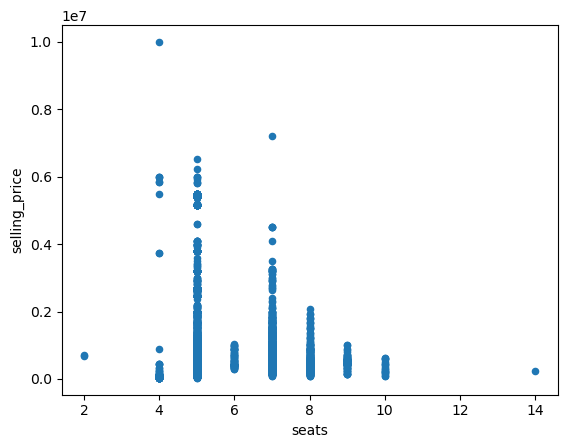

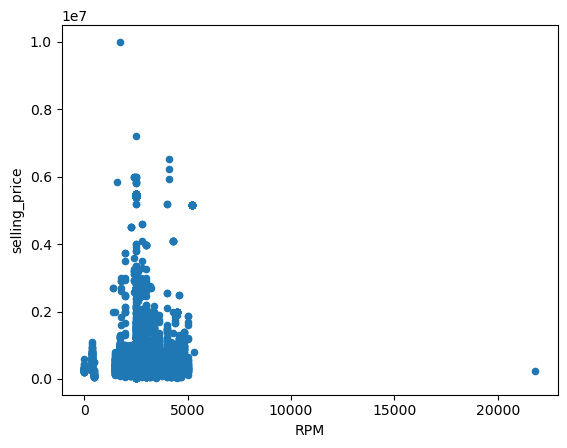

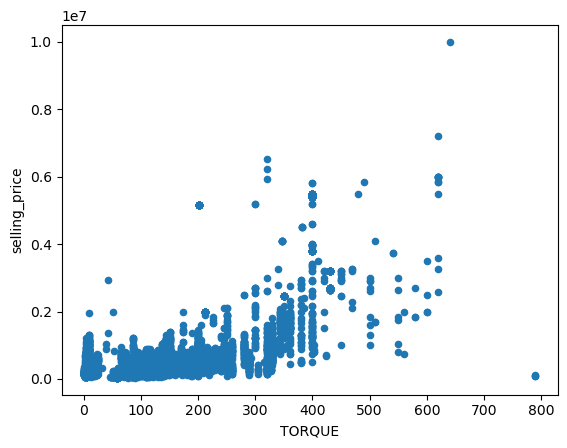

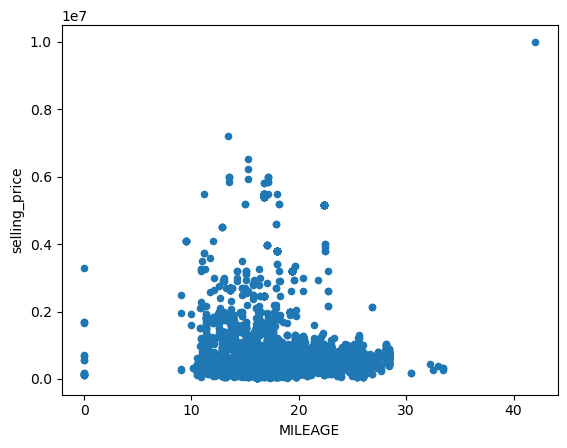

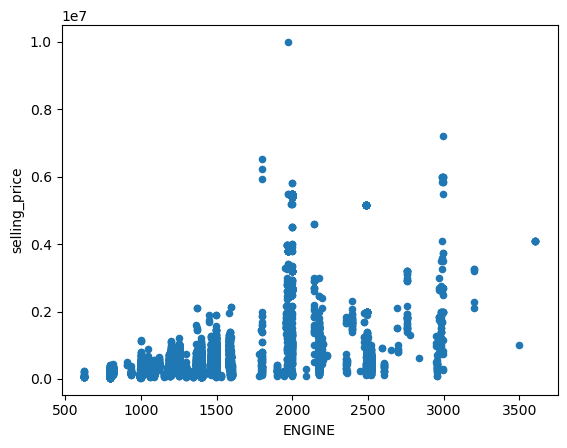

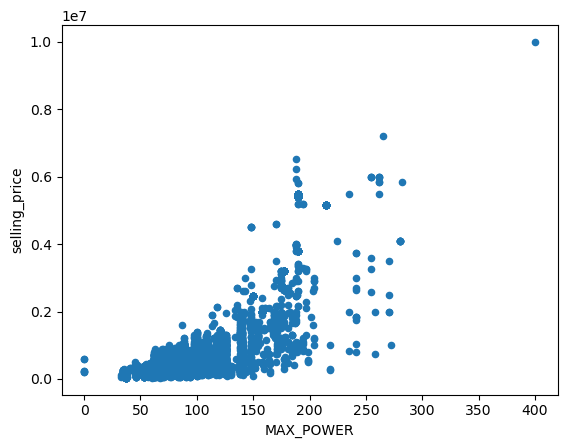

In [69]:
for columna in numerical:
    df_car.plot(x=columna, y='selling_price',kind='scatter')
plt.show()

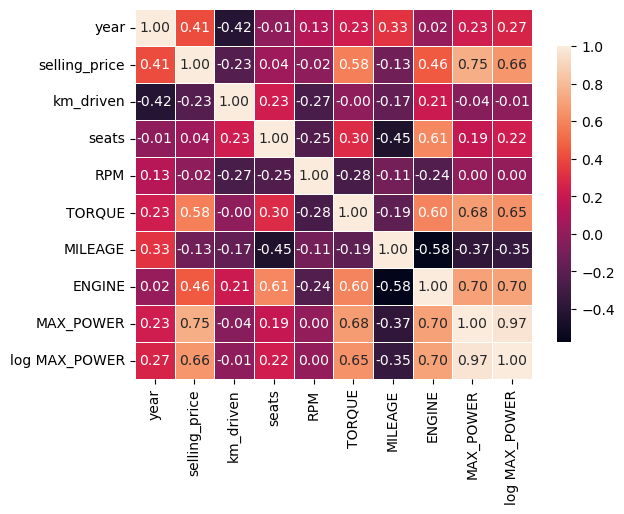

In [94]:
sns.heatmap(df_car.corr(), annot=True, fmt='.2f', linewidths=.5, cbar_kws={"shrink": .8})
plt.show()

In [7]:
# Verificamos si hay valores nulos para imputar
df_car.isnull().sum()

year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
seats            221
RPM              274
TORQUE           242
BRAND              0
MILEAGE          221
ENGINE           221
MAX_POWER        215
dtype: int64

# Preprocesamiento de datos

In [84]:
def preparacion_de_datos(df_input, target ,escalar_valores=False, multivariable=True, variable=None):
  df = df_input.dropna()
  df = pd.get_dummies(df)
  if escalar_valores: 
    scaler_X = StandardScaler(with_mean=True, with_std=True)
    scaler_X.fit(df.drop(target,axis=1))
    x = pd.DataFrame(scaler_X.transform(df.drop(target,axis=1),), columns = df.drop(target,axis=1).columns )
  else:
    x = df.drop(target,axis=1)

  if not multivariable:
    x = np.array(x[variable]).reshape(-1, 1)
    
  y = df[target]
  return x,y

In [101]:
X_car, y_car = preparacion_de_datos( df_car, "selling_price" ,escalar_valores=False, multivariable=False, variable='TORQUE')

In [102]:
# Hacemos el Split 70-30 para train-test
X_train, X_test, y_train, y_test = train_test_split(X_car, y_car,
                                                    test_size=0.3, random_state=0)

# Regresion Lineal Simple

In [103]:
from sklearn.linear_model import LinearRegression

reglin = LinearRegression( )
reglin.fit(X_train , y_train)

LinearRegression()

In [104]:
# score devuelve coeficiente de determinación, denominado R²
print( "R²: " + str(reglin.score(X_test,y_test)))

R²: 0.3154815722145926


In [105]:
reglin.intercept_

8786.279069624725

In [134]:
import plotly.express as px
predicted = reglin.predict(X_test)
fig = px.line(x=X_test[:,0], y=predicted )
fig.add_scatter(x=X_test[:,0], y=y_test, mode='markers', showlegend=False)
fig.show()

# Ejercicio
- probar el modelo con la variable de mayor correlacion, MAX_POWER
- imputar a la media los valores nulos de MAX POWER dentro de la funcion de preparacion de datos
- 